In [1]:
import pandas as pd
import numpy as np
import os
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

os.chdir('C:/Users/39329/OneDrive - ISEG/000 Dissertation/Used Car/Used-Car')

In [2]:
df_original = pd.read_csv("Dataset/vehicles.csv")

In [43]:
df = df_original.copy()

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

County has 0 non-null values. Let's proceed removing non relevant columns

In [45]:
drop_columns = ['url','region','region_url','image_url','county','posting_date','description','state','id','size','paint_color']
df.drop(columns = drop_columns,inplace=True)

Let's drop all null values and duplicates.

In [46]:
df.dropna(inplace=True)

In [47]:
df.drop_duplicates(inplace=True)
df.drop(columns='VIN',inplace=True)

## EDA

### Location

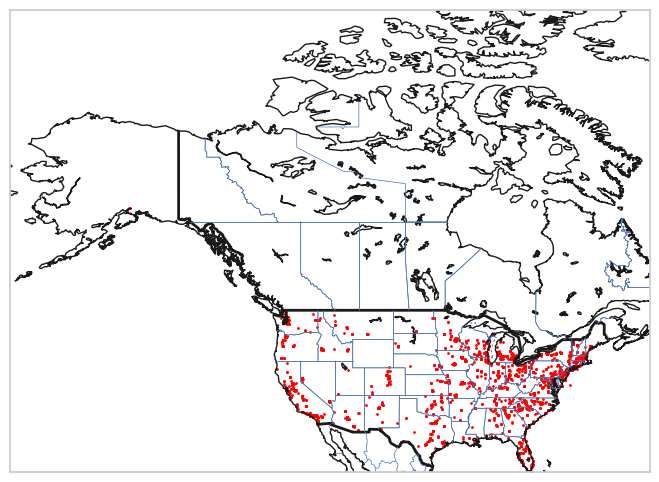

In [48]:
#create a sample of 5% of items
df_sample = df.sample(frac = 0.05)

#create my map
plt.figure(figsize=(12,6))
m = Basemap(projection='mill',
            llcrnrlat = 25,
            llcrnrlon = -170,
            urcrnrlat = 80,
            urcrnrlon = -60,
            resolution='l')
m.drawcoastlines()
m.drawcountries(linewidth=2)
m.drawstates(color='b')

#plot my points
lat = df_sample['lat'].tolist()
lon = df_sample['long'].tolist()
m.scatter(lon, lat, latlon = True, s = 1, c = 'red', marker = 'o', alpha = 1)

plt.show()

Most of the cars are in the East part of the U.S.
Let's divide into cars in West (0), Center (1) and East U.S. (2)

In [49]:
def categorize_location(row):
    if row['long'] < -105:
        return 'West'
    elif row['long'] < -80:
        return 'Center'
    else:
        return 'East'

df['location'] = df.apply(categorize_location, axis=1)

In [50]:
df.drop(columns=['lat','long'],inplace=True)

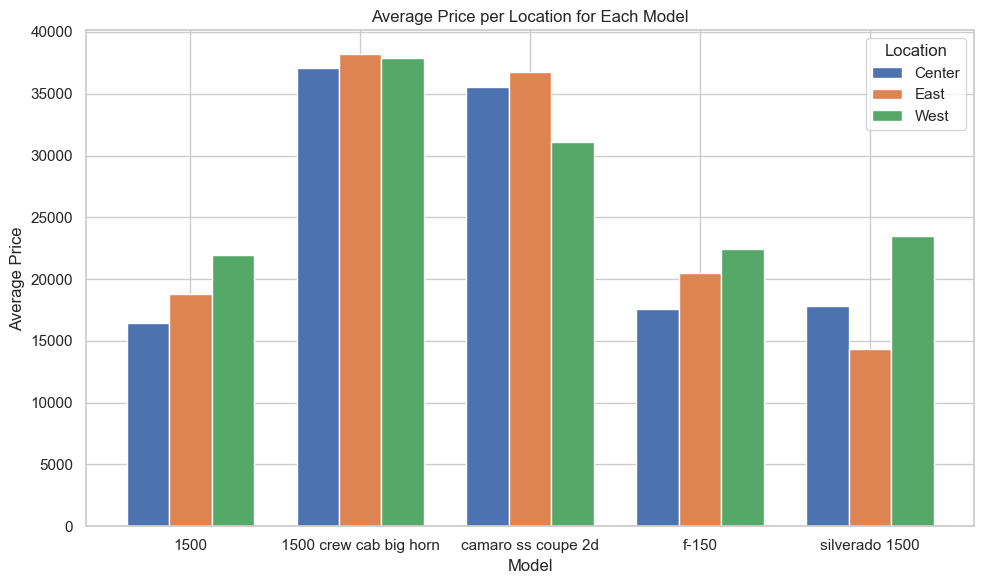

In [52]:
model_5mostcommon = df[df['model'].isin(df['model'].value_counts().nlargest(5).index)]
grouped_data = model_5mostcommon.groupby(['model', 'location'])['price'].mean().unstack()

models = grouped_data.index
locations = grouped_data.columns
x = np.arange(len(models))
bar_width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
for i, location in enumerate(locations):
    ax.bar(x + i * bar_width, grouped_data[location], width=bar_width, label=location)

ax.set_xticks(x + (bar_width * (len(locations) - 1)) / 2)
ax.set_xticklabels(models)

plt.xlabel('Model')
plt.ylabel('Average Price')
plt.title('Average Price per Location for Each Model')
plt.legend(title='Location', loc='upper right')
plt.tight_layout()
plt.show()

No patter visible with respect to car model and location amongst the top 5 models, can we remove location?

### Price

In [53]:
df['price'].value_counts().iloc[:10]

0        2235
29990     867
36990     534
37990     527
6995      526
33990     515
7995      476
39590     475
39990     470
27990     457
Name: price, dtype: int64

Remove rows where price is 0

In [54]:
df = df[df['price'] != 0]

In [55]:
df.price.describe()

count     47396.000000
mean      20386.134758
std       13723.741559
min           1.000000
25%        8860.250000
50%       16999.000000
75%       30977.000000
max      155000.000000
Name: price, dtype: float64

Cars priced at 1 are incorrect.

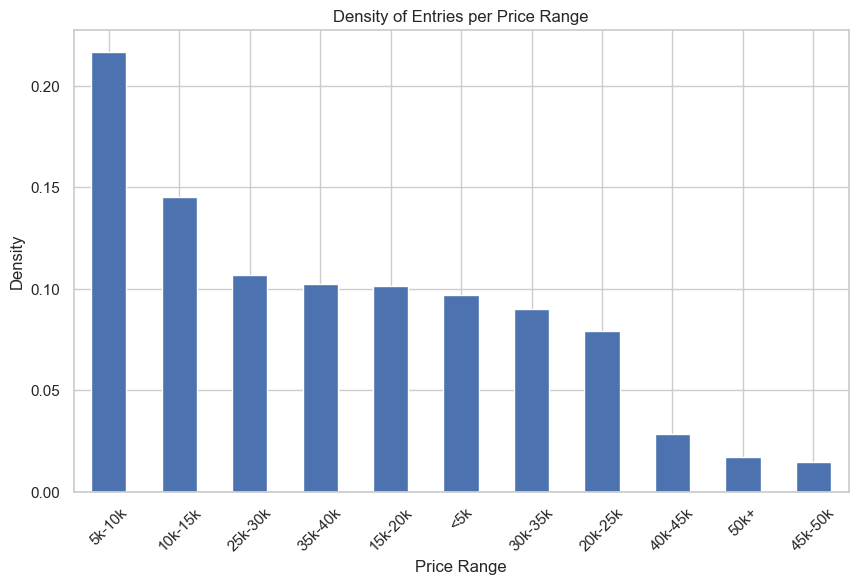

In [56]:
price_ranges = [0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, float('inf')]
price_range_labels = ['<5k', '5k-10k', '10k-15k', '15k-20k', '20k-25k', '25k-30k', '30k-35k', '35k-40k', '40k-45k', '45k-50k', '50k+']

# Create a new column in the DataFrame to categorize prices into ranges
df['price_range'] = pd.cut(df['price'], bins=price_ranges, labels=price_range_labels)

# Calculate the density of entries per price range
price_range_counts = df['price_range'].value_counts(normalize=True)

# Create a bar chart
plt.figure(figsize=(10, 6))
price_range_counts.plot(kind='bar')
plt.title('Density of Entries per Price Range')
plt.xlabel('Price Range')
plt.ylabel('Density')
plt.xticks(rotation=45)
plt.show()

df.drop(columns = 'price_range', inplace =True)

Data has a left-skewed distribution, should I apply a log transformation?

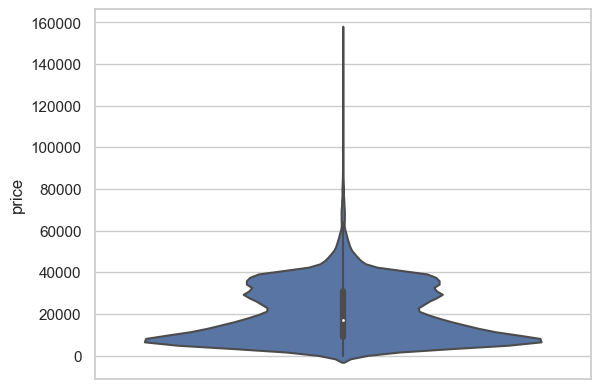

In [57]:
sns.violinplot(y='price', data=df);

Postings with price under ＄100 and above ＄60k will be removed

In [58]:
df.drop(df[df['price']<=100].index, inplace = True)
df.drop(df[df['price']>=6000].index, inplace = True)

### Title Status

In [59]:
df['title_status'].value_counts()

clean         6047
rebuilt        146
salvage         92
lien            17
missing         12
parts only       4
Name: title_status, dtype: int64

Only 'clean' postings are useful for the purpose of this model, all others will be deleted

In [60]:
df = df[df['title_status'] == 'clean']
df.drop('title_status', axis=1, inplace=True)

### Year

<Axes: xlabel='year', ylabel='Count'>

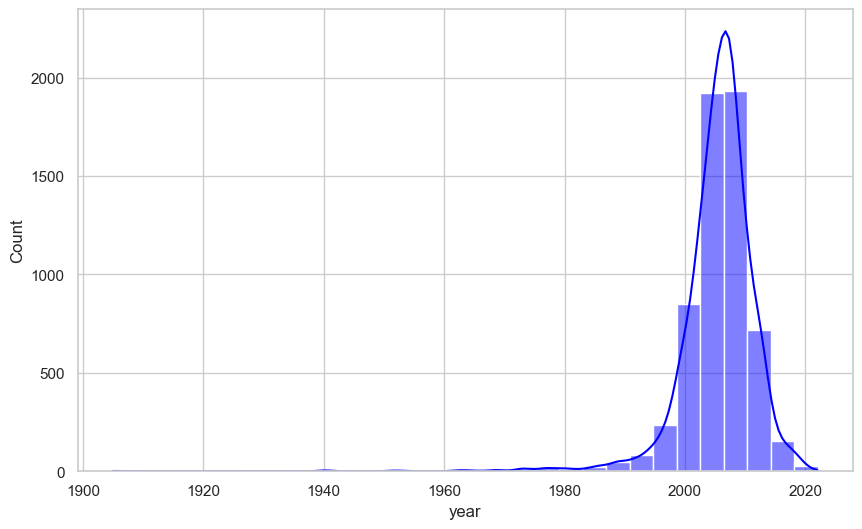

In [61]:
sns.set(style='whitegrid')

plt.figure(figsize=(10, 6))  
sns.histplot(df['year'], kde=True, bins=30, color='blue')

Reduce postings to years 1991 to 2020 (range of 30 years)

In [62]:
df = df[(df['year'] >= 1990) & (df['year']<2021)]

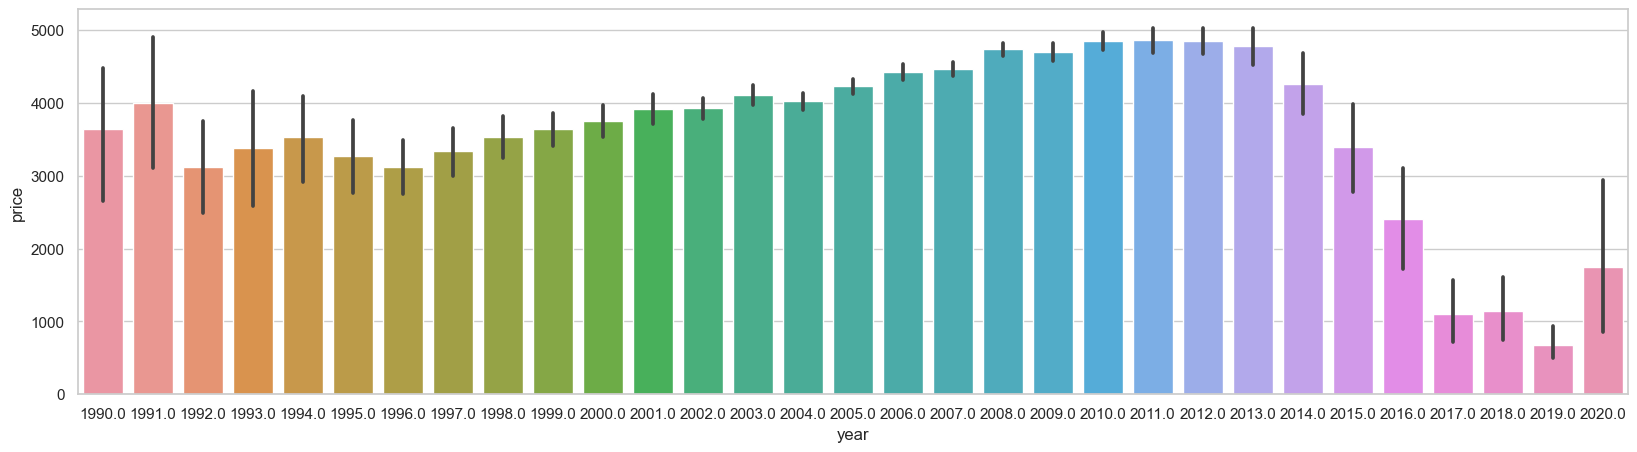

In [63]:
plt.figure(figsize=(20,5))
sns.barplot(data= df,x="year", y= "price")
plt.show()

Huge drop in used car prices after 2013

### Manufacturers

In [64]:
manufacturer_counts = df['manufacturer'].value_counts()
manufacturer_counts

ford             778
chevrolet        705
toyota           671
honda            601
nissan           345
hyundai          234
dodge            214
jeep             199
chrysler         197
subaru           176
volkswagen       168
mazda            150
kia              138
buick            132
pontiac          122
bmw              118
gmc              112
mercedes-benz    101
volvo             92
saturn            88
mercury           70
lexus             70
cadillac          63
mitsubishi        62
lincoln           57
acura             56
ram               43
audi              38
mini              38
infiniti          37
jaguar            22
fiat              21
rover              8
alfa-romeo         2
porsche            2
land rover         1
Name: manufacturer, dtype: int64

In [65]:
df = df[df['manufacturer'].isin(manufacturer_counts[manufacturer_counts > 100].index)]
df.reset_index(drop=True, inplace=True)

Keep only manufacturers who have at least 100 entries

### Condition

In [66]:
df['condition'].value_counts()

excellent    2351
good         2204
fair          309
like new      276
new            12
salvage         9
Name: condition, dtype: int64

In [67]:
condition_count = df['condition'].value_counts()

In [68]:
condition_count[condition_count > 100].index
df = df[df['condition'].isin(condition_count[condition_count > 100].index)]

### Trasmission

In [69]:
df['transmission'].value_counts()

automatic    4688
manual        428
other          24
Name: transmission, dtype: int64

In [70]:
df = df[df['transmission'] != 'other']

### Fuel

In [71]:
df['fuel'].value_counts()

gas         4965
hybrid        91
diesel        34
other         19
electric       7
Name: fuel, dtype: int64

In [72]:
df = df[df['fuel']=='gas'] 
df.drop(columns = 'fuel',inplace = True)

### Converting Categorical Variables

In [73]:
df.head()

,price,year,manufacturer,model,condition,cylinders,odometer,transmission,drive,type,location
0,4000,2002.0,toyota,echo,excellent,4 cylinders,155000.0,automatic,fwd,sedan,Center
1,2500,1995.0,bmw,525i,fair,6 cylinders,110661.0,automatic,rwd,sedan,Center
2,5500,2010.0,hyundai,accent,good,4 cylinders,114988.0,automatic,fwd,hatchback,Center
3,5950,2008.0,honda,accord,excellent,4 cylinders,190000.0,automatic,fwd,sedan,Center
4,4900,2007.0,volkswagen,jetta gli fahrenheit,good,4 cylinders,243730.0,manual,fwd,sedan,Center


In [74]:
cylinders_dict = {'other':0,'3 cylinders':1,'4 cylinders':2,'5 cylinders':3,'6 cylinders':4, '8 cylinders':5}
df['cylinders'] = df['cylinders'].replace(cylinders_dict)

In [75]:
conditions_dict = {'like new':0,'excellent':1,'good':2,'fair':3}
df['condition'] = df['condition'].replace(conditions_dict)

In [79]:
df = pd.get_dummies(df,columns=['manufacturer','transmission','drive','location','type'],drop_first = True)

Missing are type, paint_color, model

In [80]:
df.head()

,price,year,model,condition,cylinders,odometer,manufacturer_buick,manufacturer_chevrolet,manufacturer_chrysler,manufacturer_dodge,...,type_convertible,type_coupe,type_hatchback,type_mini-van,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon
0,4000,2002.0,echo,1,2,155000.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2500,1995.0,525i,3,4,110661.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,5500,2010.0,accent,2,2,114988.0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,5950,2008.0,accord,1,2,190000.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,4900,2007.0,jetta gli fahrenheit,2,2,243730.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
